In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
def get_llm(fn):
    llm = []
    for N in range(2,12):
        df = pd.read_csv('../tsne/tsne.{}.csv'.format(N))
        df = df[df['fn']==fn]
        # llm.append((df['ILmr'] + df['DLmr'] + df['DLmw']).values[0])
        llm.append((df['DLmr'] + df['DLmw']).values[0])
    return llm
    
def get_perf(fn, bench_csv, flop):
    df = pd.read_csv(bench_csv)
    perf_df = df[['n', fn]].head(10)
    N = 2 ** perf_df['n']
    perf_df['flop'] = flop(N)
    perf_df['perf'] = perf_df['flop'] / perf_df[fn]
    perf_df['llm'] = get_llm(fn)
    perf_df['In'] = perf_df['flop'] / (64 * perf_df['llm'])
    return perf_df

def plot_perf(perf_df, ax, label):
    x = perf_df['In'].to_numpy()
    y = perf_df['perf'].to_numpy()
    line, = ax.plot(x, y, '-o', label=label)
    ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.003, color=line.get_color()) 
    

In [3]:
tsne_bench = '../benchmark/tsne_full_100.csv'
v1 = get_perf('tsne_baseline', tsne_bench, lambda n : 2329*n*n - 728*n + 100*(13*n*n + 13*n + 2))
v2 = get_perf('tsne_scalar', tsne_bench, lambda n : 1938.5*n*n + 1230.5*n + 100*(13*n*n + 13*n + 2))
v3 = get_perf('tsne_vec', tsne_bench, lambda n : 2788.5*n*n + 380.5*n + 100*(13*n*n + 13*n + 2))
v4 = get_perf('tsne_vec3', tsne_bench, lambda n : 2788.5*n*n + 380.5*n + 100*(13*n*n + 13*n + 2))
v5 = get_perf('tsne_no_vars', tsne_bench, lambda n : 2788.5*n*n + 380.5*n + 100*(20.5*n*n + 15.5*n + 6))

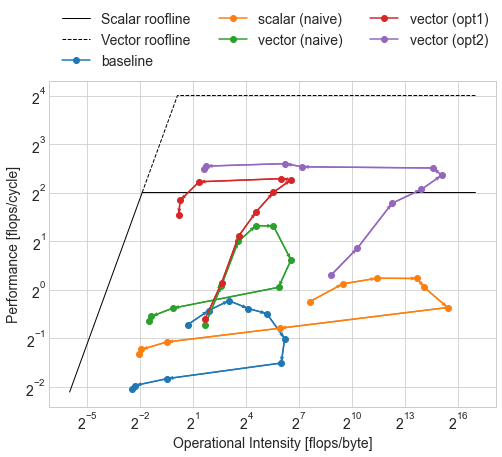

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
beta = 14.8 #bytes/cycle
ax.plot([1/64, 4/beta, 2**17], [beta/64, 4, 4], color='k', lw=1, label='Scalar roofline')
ax.plot([4/beta, 16/beta, 2**17], [4, 16, 16], color='k', lw=1, linestyle='--', label='Vector roofline') 
plot_perf(v1, ax, 'baseline')
plot_perf(v2, ax, 'scalar (naive)')
plot_perf(v3, ax, 'vector (naive)')
plot_perf(v4, ax, 'vector (opt1)')
plot_perf(v5, ax, 'vector (opt2)')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.set_xlabel('Operational Intensity [flops/byte]')
ax.set_ylabel('Performance [flops/cycle]')
ax.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=3)

In [5]:
fig.savefig('tsne_roofline.pdf', bbox_inches='tight')